# Tinytol apperture design
---
### 15mm apperture testing
#### Single half wave step at 525nm (central green band)
**What is the ideal pupil design that gives a central peak brighness equal to that of the outer peaks (bed of nails)**

1/10$^{th}$ of a wavelength singusoidal grating (only a single dimension)

use spiral phase plate to invert sinusoidal function

central region should be ~1/10$^{th}$ total pupil size

In [1]:
# Add local scripts to module search path
import sys
import matplotlib.pyplot as plt
import numpy as np
import proper
proper.print_it = False
from pathlib import Path
path = str(Path().resolve())
sys.path.append((path[0:len(path)-len("notebooks/TinyTol")]) + "toliman-proper")
from math import sin, log10, cos, atan2, hypot
import math
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from prescription_quad import prescription_quad
from proper_tools import form_detector_image
from FT_model import model_FT
from get_wf import get_wf
from copy import deepcopy

prescription = 'prescription_quad'
image_path = "Images/"

def binarized_ringed_flipped(r, phi, phase, thresh=0.0, white=0, empty=0., r_max=300., r_min=50., r_split=246.):
        
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    

    s = 0.1501/300. # m/internal sampling dist

    black = phase
    v = empty
    r = r/s
    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        if (r>r_split): # Outer rim
            if (c3<thresh):
                v=black if (c1*c2*c3>thresh) else white
            else:
                if (sin(chi3/2.)>thresh):
                    v = black
                else:
                    v=black if (c1*c2*c3>thresh) else white 
        else: # Main spiral
            v=black if (c1*c2*c3>thresh) else white
    else:
        v = black
    return v

/Users/louis/.local/lib/python3.7/site-packages/pyfits-3.5-py3.7-macosx-10.7-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
fl = 0.15                        # Focal length (m)
app = 0.015                      # Apperture (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)
gridsize = 2048                  # size of the grid that the simulation is run on
npixels = 1024                   # Size of detector, in pixels
ratio = 0.5                      # ratio  of gridsize to appreture size (ignore)
wl_vals = [0.525]                # Wavelength values (micrometers)
wl_weights = [1.]                # Wavelength relative intensities

phase = 525                      # Has units of nm
r_max = 15
r_min = 3.02
r_split = 12.5

def generate_pupil(r, phi, phase=phase, r_max=r_max, r_min=r_min, r_split=r_split):
    phase = phase*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase, r_max=r_max, r_min=r_min, r_split=r_split)

spiral = generate_pupil          # Spiral function to be run

tinytol_settings = {
                    'diam': app,                # telescope diameter in meters
                    'm1_fl': fl,                # primary focal length (m)
                    'beam_ratio': ratio,        # Initial beam width/grid width
                    'opd_func': spiral
                    }  

mask_size = tinytol_settings['diam']
foc_length = tinytol_settings['m1_fl']
chip_dim = npixels
pix_size = detector_pitch

source = {
            'wavelengths': wl_vals,
            'weights': wl_weights,
            'settings': tinytol_settings
            }

sources = [source]

In [3]:
%%time

tinytol_settings['get_wf'] = True
tinytol_settings['beam_ratio'] = 0.99
wfo, wf, sampling = prescription_quad(wl_vals[0]*1e-6,gridsize,PASSVALUE=tinytol_settings)
tinytol_settings['get_wf'] = False
tinytol_settings['beam_ratio'] = ratio

Got wavefront
CPU times: user 9.26 s, sys: 317 ms, total: 9.58 s
Wall time: 8.41 s


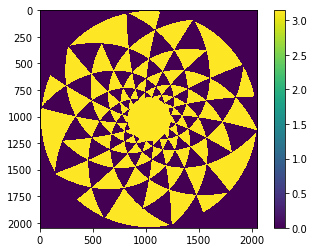

In [5]:
plt.imshow(np.abs(np.angle(wf)))
plt.colorbar()
plt.show()

In [6]:
%%time

new_mask = deepcopy(wf)
size = gridsize
# cycles = 64
cycles = 128 # 128 gives more power in the 0th fringe 
a = size//cycles
ratio = 1/10

for y in range(size):
    for x in range(size):        
        if np.abs(new_mask[y][x]) > 0:
            if np.angle(new_mask[y][x]) < -0.1:
                if x%a <= a*ratio or y%a <= a*ratio:
                    new_mask[y][x] = np.complex(1,0)
                else:
                    new_mask[y][x] = -np.complex(1,0)
            else:
                if (x+(a//2))%a <= a*ratio or (y+(a//2))%a <= a*ratio:
                    new_mask[y][x] = -np.complex(1,0)
                else:
                    new_mask[y][x] = np.complex(1,0)

CPU times: user 20.3 s, sys: 31.5 ms, total: 20.3 s
Wall time: 20.2 s


In [29]:
print(np.angle(np.complex(1,0)))
print(np.angle(-np.complex(1,0)))

0.0
-3.141592653589793


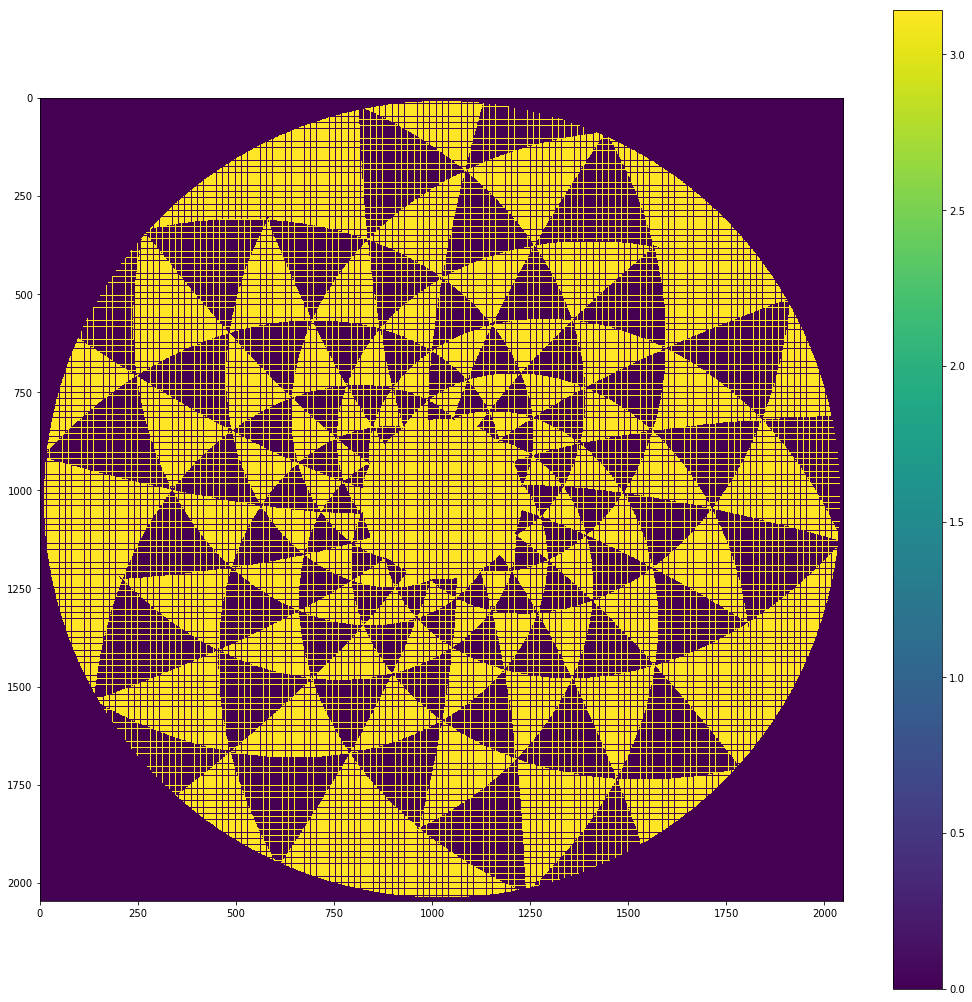

In [7]:
plt.figure(figsize=(18,18))
plt.imshow(np.abs(np.angle(new_mask)))
# plt.imshow(np.abs(new_mask))
plt.colorbar()
plt.show()

In [8]:
%%time
# proper = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)
mask = deepcopy(wf)
new_FT = model_FT(new_mask, mask_size, chip_dim, [wl_vals[0]*1e-6], foc_length, pix_size)
# FT = model_FT(mask, mask_size, chip_dim, [wl_vals[0]*1e-6], foc_length, pix_size)

CPU times: user 12.8 s, sys: 4.44 s, total: 17.3 s
Wall time: 11.4 s


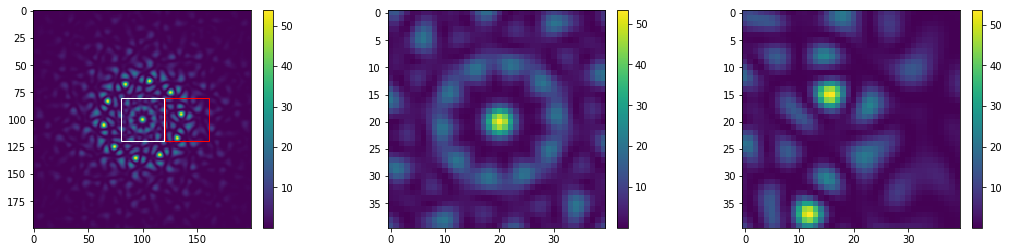

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
size = 200
# size = 1024

# FT_out = FT*1e5/np.sum(FT)
# c = FT_out.shape[0]/2

FT_out = new_FT*1e5/np.sum(new_FT)
c = FT_out.shape[0]/2

im_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[0].imshow(im_out)
# im = axs[0].imshow(im_out, norm=LogNorm())
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

rect = patches.Rectangle((121,80),40,40,linewidth=1,edgecolor='r',facecolor='none')
axs[0].add_patch(rect)
rect = patches.Rectangle((80,80),40,40,linewidth=1,edgecolor='w',facecolor='none')
axs[0].add_patch(rect)

size = 40
ctr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[1].imshow(ctr_out)
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)

offset = 40
cnr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2)+offset:int(c+size//2)+offset]
im = axs[2].imshow(cnr_out)
plt.colorbar(im,ax=axs[2],fraction=0.046, pad=0.04)

plt.show()

To find the ideal layout we will introduce a quality factor Q defined as the ratio of the max values of the two image (minus 1) such that our ideal pupil will have a Q value of 0

In [10]:
max_central = ctr_out.max()
max_outer = cnr_out.max()
Q = np.abs(max_central/max_outer - 1)

print("Central peak: {:.2f}".format(max_central))
print("Outer peak: {:.2f}".format(max_outer))
print("Quality factor: {:.6f}".format(Q))

Central peak: 53.24
Outer peak: 53.51
Quality factor: 0.004980


### Find the values that seperate the layers of the pupil

In [396]:
import math
import numpy as np

def generate_spiral(gridsize, aperture, r_max, r_min, r_split):
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = math.atan2(y, x)
            r = sampling*math.hypot(x,y)
            wfarr[i][j] = spiral(r, phi, aperture, r_max, r_min, r_split)
    return wfarr

def spiral(r, phi, aperture, r_max, r_min, r_split):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    
    thresh = 0
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    
    
    offset0 = np.complex(-(3**0.5)/2,1/2)
    offset1 = np.complex(-1**0.5,1**0.5)
    offset2 = np.complex(-1/2,(3**0.5)/2)
    offset3 = np.complex(0,1) 
    offset4 = np.complex(1/2,(3**0.5)/2)
    offset5 = np.complex(1**0.5,1**0.5)
    offset6 = np.complex(1**0.5, -1**0.5)
    offset7 = np.complex((3**0.5)/2,1/2)

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        if (r>=r_split[0] and r <= r_max):
            
            if (c3<thresh):                                             # The 'first' and 'third' sections of the spiral
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
#                 v = black
            else:
                if (sin(chi3/2.)>thresh):                               # The 'second' section of the spiral
                    v = black
#                     v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:                                                   # The 'fourth' section of the spiral
#                     v = black
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3
    
        elif (r>=r_split[1] and r<r_split[0]):
            
            if (c3<thresh):  
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
#                 v = black
            else:
                if (sin(chi3/2.)>thresh):
#                     v = black
                    v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3

        elif (r>=r_split[2] and r<r_split[1]):
        
            if (c3<thresh):  
#                 v = black
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
            else:
                if (sin(chi3/2.)>thresh):
#                     v = black
                    v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black
#                     v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3
                    
        elif (r>=r_split[3] and r<r_split[2]):
            
            if (c3<thresh):  
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
            else:
                if (sin(chi3/2.)>thresh):
#                     v = black
                    v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3

        elif (r>=r_split[4] and r<r_split[3]):
            
            if (c3<thresh):  
                v = black if (c1*c2*c3>thresh) else white
#                 v = offset4 if (c1*c2*c3>thresh) else offset5  
            else:
                if (sin(chi3/2.)>thresh):
                    v = black
#                     v=black if (c1*c2*c3>thresh) else white
#                     v = offset0 if (c1*c2*c3>thresh) else offset1
                else:
                    v = black if (c1*c2*c3>thresh) else white
#                     v = offset2 if (c1*c2*c3>thresh) else offset3

        else: # Main spiral
            v = black if (c1*c2*c3>thresh) else white

    elif r < r_min:
        v = black
    return v

In [397]:
%%time
aperture = 0.015                 # Aperture (m)
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

r_max = 15.15
r_min = 0.62

split_values = [12.4, 8.33, 5.6, 3.75, 2.5, 1.7, 1.14, 0.76]
r_split = split_values[0]
r_split = split_values[:5]
# r_split = [split_values[-1]]

wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, r_split)

CPU times: user 14.1 s, sys: 30.4 ms, total: 14.1 s
Wall time: 14.2 s


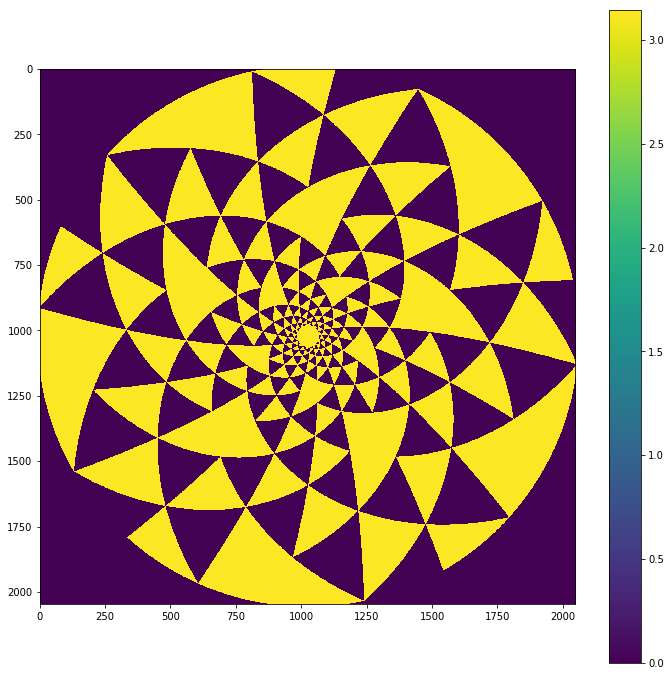

In [398]:
plt.figure(figsize=(12,12))
plt.imshow(np.abs(np.angle(wf)))
plt.colorbar()
plt.show()

In [399]:
%%time
FT = model_FT(wf, aperture*1e-3, npixels, [wl], fl, detector_pitch)

CPU times: user 6.73 s, sys: 4.35 s, total: 11.1 s
Wall time: 9.12 s


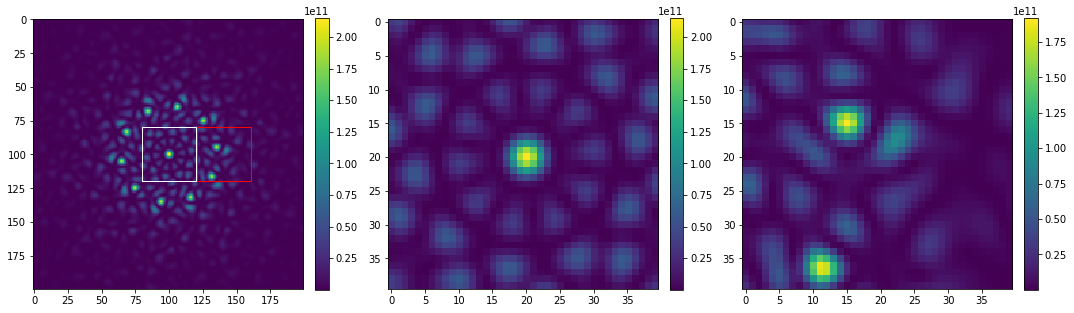

In [431]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
size = 200
# size = 1024

# FT_out = FT*1e5/np.sum(FT)
c = FT.shape[0]/2
FT_out = FT


im_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[0].imshow(im_out)
# im = axs[0].imshow(im_out, norm=LogNorm())
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

rect = patches.Rectangle((121,80),40,40,linewidth=1,edgecolor='r',facecolor='none')
axs[0].add_patch(rect)
rect = patches.Rectangle((80,80),40,40,linewidth=1,edgecolor='w',facecolor='none')
axs[0].add_patch(rect)

size = 40
ctr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im = axs[1].imshow(ctr_out)
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)

offset = 40
cnr_out = FT_out[int(c-size//2):int(c+size//2),int(c-size//2)+offset:int(c+size//2)+offset]
im = axs[2].imshow(cnr_out)
plt.colorbar(im,ax=axs[2],fraction=0.046, pad=0.04)

plt.show()

---

General plan moving forward: Break up each ringed region into their own function with a set of 'on and off' switches that turn the different 'quadrants' of the repeating pattern off and on. Then iteratively turning the different regions on and off and trying all the different permutations of the qudrants we should be able to explore the entire parameter space.

note: The size of the inner region of the pupil was chosen to be as small as possible (to be determined later by the precision of the tools that make it) since there is an ~2% leakage of photons that will not see the pupil, this will form the power in the central region of the detector (0th fringe). The size of this inner region can always be adjusted later to direct more power to the central region if neccesary.

---

### Split the image into central and outer region

Create an circular image with some radii to use as the 'cental region' and the rest as the 'outer region'. Optimise for the lowest peak power in the outer region, noting that the quality factor stays below a certain threshold (ensuring we dont have false positive results where all the power is directed to the central region).

In [26]:
def split_central(image, npixels, radius):
    central = np.zeros([npixels, npixels], dtype = np.float)
    outer = np.zeros([npixels, npixels], dtype = np.float)
    c = npixels//2
    for i in range(npixels):
        for j in range(npixels):
            x = i - c
            y = j - c
            r = math.hypot(x,y)
            if r <= radius:
                central[i][j] = image[i][j]
            else:
                outer[i][j] = image[i][j]
    return central, outer 

# radius = 13
# central, outer = split_central(FT, npixels, radius)

---

### Define a "quality factor" representing to ratio of peak brightness in the two regions

In [27]:
def get_Q(central, outer, mod=False):
    """
    Gets the "quality factor" defined as the ratio of the peak brightnesses of the central and outer region.
    A value closer to zero indicates that the peak brightnesses is similar in both regions
    A value above zero indicated a higher peak power in the outer region, below zero indicates higher peak in central region
    mod returns the absolute value of Q, |Q|
    """
    max_central = central.max()
    max_outer = outer.max()
    if not mod:
        return max_outer/max_central - 1
    return np.abs(max_outer/max_central - 1)
        
# Q = get_Q(central, outer)
# print("Quality factor: {:.6f}".format(Q))

---

## How much power is lost in the regions out past the edge of the detector?
How small can we make our detector (to reduce computation time) without affecting out results? 

In [28]:
%%time
# FT_512 = model_FT(wf, aperture*1e-3, 512, [wl], fl, detector_pitch)
# FT_1024 = model_FT(wf, aperture*1e-3, 1024, [wl], fl, detector_pitch)
# FT_2048 = model_FT(wf, aperture*1e-3, 2048, [wl], fl, detector_pitch)
# FT_4096 = model_FT(wf, aperture*1e-3, 4096, [wl], fl, detector_pitch)
# FT_8192 = model_FT(wf, aperture*1e-3, 8192, [wl], fl, detector_pitch)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [29]:
# print("How much power is lost as a percentage of the total power?\nTotal power is defined as the power that is collected by a 8192*8192 pixel detector\n")
# print("512:  {:.0f}% of total power".format(100*np.sum(FT_512)/np.sum(FT_8192)))
# print("1024: {:.0f}% of total power".format(100*np.sum(FT_1024/np.sum(FT_8192))))
# print("2048: {:.0f}% of total power".format(100*np.sum(FT_2048/np.sum(FT_8192))))
# print("4096: {:.0f}% of total power".format(100*np.sum(FT_4096/np.sum(FT_8192))))

Given that the FT code runs relatively efficently on a 1024 pixel detector, we will use this as our base line (ie assume that it collects all of the power)

---

### Functions to make viewing images easier

In [30]:
def display_split(image, npixels=1024, radius=13, size=200, inner_size=50, sizes=(12,6)):
    central, outer = split_central(image, npixels, radius)
    fig, axs = plt.subplots(1, 2, figsize=sizes)
    c = image.shape[0]/2

    im_out = central[int(c-inner_size//2):int(c+inner_size//2),int(c-inner_size//2):int(c+inner_size//2)]
    im = axs[0].imshow(im_out)
    plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

    ctr_out = outer[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    im = axs[1].imshow(ctr_out)
    plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)

    plt.show()

def display(wf, image, size=200, sizes=(12,6)):
    fig, axs = plt.subplots(1, 2, figsize=sizes)
    
    im = axs[0].imshow(np.abs(np.angle(wf)))
    plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
    
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    im = axs[1].imshow(im_out)
    plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
    
    plt.show()
    
def display_spiral(wf,sizes=(12,12)):
    plt.figure(figsize=sizes)
    plt.imshow(np.abs(np.angle(wf)))
    plt.colorbar()
    plt.show()

---

### What metric should we use to determine a 'good' pupil design?

Simply using the lowest peak power in the outer region can lead to false positives, ie designs that put most of the power in the central peak leading to a lower peak in the outer regions. Hence we shall use low peak power in the outer regions, and disregard all results that give a non-negative Q (non-negative Q's indicate that the peak power in the central region is larger than that of the outer region) - thereby only giving us results with a low outer peak that is not caused by directing that power to the central region.

In [31]:
def test_quality(wf, npixels=1024, radius=10, print_Q=False, show=False):
    """
    Runs the FT and analysis on the wavefront
    Return the max of out outer region if the central peak brightness is less that the outer
    Else returns -1
    """
    
    FT = model_FT(wf, aperture*1e-3, npixels, [wl], fl, detector_pitch)
    central, outer = split_central(FT, npixels, radius)
    Q = get_Q(central, outer)
    if print_Q:
        print(print("Quality factor: {:.6f}".format(Q)))

    if show:
        display(wf, FT)
        display_split(FT, radius=radius)
        
    if Q < 0: # Is there a higher peak power in the central region of the detector than the outer ring?
        return -1, Q, FT # Disregard these results
    else:
        return outer.max(), Q, FT

---

### Automating the permutations of the pupil design (modularising)

In [32]:
def normal(r, black, white, c1, c2, c3, chi1, chi2, chi3):
    v = black if (c1*c2*c3>0) else white
    return v

def fill_odd(r, black, white, c1, c2, c3, chi1, chi2, chi3): # Operates on a different set of split values
    if (c3<0):
        v = black
    else:                                
        v = black if (c1*c2*c3>0) else white
    return v

def fill_even(r, black, white, c1, c2, c3, chi1, chi2, chi3):
    if (c3<0):
        v = black if (c1*c2*c3>0) else white
    else:                                
        v = black
    return v

def fill_1(r, black, white, c1, c2, c3, chi1, chi2, chi3): # Operates on a different set of split values
    if (c3<0) and not (sin(chi3/2.)>0):
        v = black
    else:                                
        v = black if (c1*c2*c3>0) else white
    return v

def fill_2(r, black, white, c1, c2, c3, chi1, chi2, chi3):
    if (c3<0) or not (sin(chi3/2.)>0):
        v = black if (c1*c2*c3>0) else white
    else:
        v = black
    return v

def fill_3(r, black, white, c1, c2, c3, chi1, chi2, chi3): # Operates on a different set of split values
    if (c3<0) and (sin(chi3/2.)>0):
        v = black
    else:                                
        v = black if (c1*c2*c3>0) else white
    return v

def fill_4(r, black, white, c1, c2, c3, chi1, chi2, chi3):
    if (c3<0) or (sin(chi3/2.)>0):
        v = black if (c1*c2*c3>0) else white
    else:
        v = black
    return v

In [33]:
def generate_spiral(gridsize, aperture, r_max, r_min, r_split):
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = math.atan2(y, x)
            r = sampling*math.hypot(x,y)
            wfarr[i][j] = spiral(r, phi, aperture, r_max, r_min, r_split)
    return wfarr

def spiral(r, phi, aperture, r_max, r_min, r_split):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    
    offset0 = np.complex(-(3**0.5)/2,1/2)
    offset1 = np.complex(-1**0.5,1**0.5)
    offset2 = np.complex(-1/2,(3**0.5)/2)
    offset3 = np.complex(0,1) 
    offset4 = np.complex(1/2,(3**0.5)/2)
    offset5 = np.complex(1**0.5,1**0.5)
    offset7 = np.complex((3**0.5)/2,1/2)

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        
        if (r>=r_split[0] and r <= r_max):
            v = fill_1(r, black, white, c1, c2, c3, chi1, chi2, chi3)
    
        elif (r>=r_split[1] and r<r_split[0]):
            v = fill_2(r, black, white, c1, c2, c3, chi1, chi2, chi3)

        elif (r>=r_split[2] and r<r_split[1]):
            v = fill_3(r, black, white, c1, c2, c3, chi1, chi2, chi3)
                    
        elif (r>=r_split[3] and r<r_split[2]):
            v = fill_4(r, black, white, c1, c2, c3, chi1, chi2, chi3)

        elif (r>=r_split[4] and r<r_split[3]):
            v = normal(r, black, white, c1, c2, c3, chi1, chi2, chi3)

            
        else: # Rest of spiral
            v = black if (c1*c2*c3>0) else white

    elif r < r_min:
        v = black
    return v

### Set the simulation paramters and run the code

In [34]:
def generate_spiral2(gridsize, aperture, r_max, r_min, splits, settings):
    split_odd = splits[0]
    split_even = splits[1]
    first = settings[0]
    second = settings[1]
    third = settings[2]
    fourth = settings[3]
    
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = math.atan2(y, x)
            r = sampling*math.hypot(x,y)
            wfarr[i][j] = spiral2(r, phi, aperture, r_max, r_min, split_odd, split_even, first, second, third, fourth)
    return wfarr

def spiral2(r, phi, aperture, r_max, r_min, split_odd, split_even, first, second, third, fourth):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        
        if c3 >= 0:
            if sin(chi3/2.) > 0:                  # First  quadrant
                for i in range(len(first)):
                    if first[i] == True and (r <= split_odd[i] and r > split_odd[i+1]):
                        v = black
                        return v
            else:                                 # Third quadrant
                for i in range(len(third)):
                    if third[i] == True and (r <= split_odd[i] and r > split_odd[i+1]):
                        v = black
                        return v
                    
            v = black if (c1*c2*c3>0) else white
            return v
        
        else: # In the even regime
            if sin(chi3/2.) <= 0:                 # Second  quadrant
                for i in range(len(second)):
                    if second[i] == True and (r <= split_even[i] and r > split_even[i+1]):
                        v = black
                        return v
            else:                                 # Fourth quadrant
                for i in range(len(fourth)):
                    if fourth[i] == True and (r <= split_even[i] and r > split_even[i+1]):
                        v = black
                        return v
                
            v = black if (c1*c2*c3>0) else white
            return v

    elif r < r_min:
        v = black
    return v

In [12]:
aperture = 0.015                 # Aperture (m)
gridsize = 2048
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]
r_max = split_values[0]
r_min = split_values[-1]

split_even =[15.5, 10.17, 6.83, 4.575, 3.05, 2.07, 1.4, 0.925, 0.62] 
second = [0,0,0,0,0,0,0,0]
fourth = [0,0,0,0,0,0,0,0]

split_odd = [15.5, 12.4, 8.33, 5.6, 3.75, 2.5, 1.7, 1.14, 0.76, 0.62]
first = [0,0,0,0,0,0,0,0,0]
third = [0,0,0,0,0,0,0,0,0]

splits = (split_odd, split_even)
settings = (first, second, third, fourth)

Quality factor: 4746.847355
None


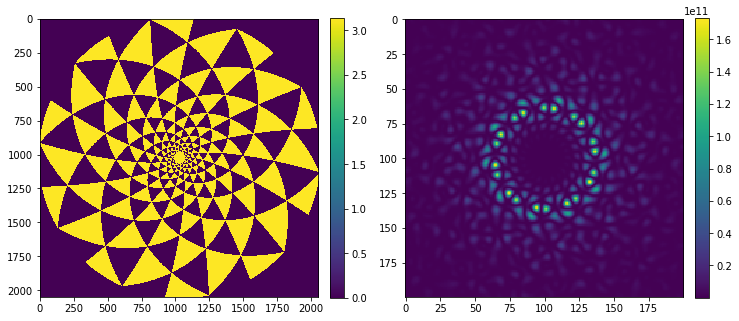

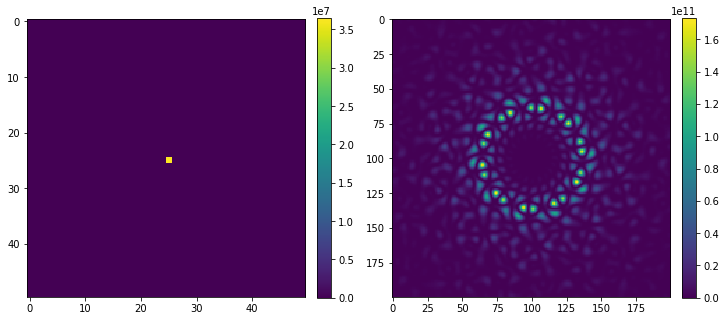

173381172797.82977
CPU times: user 20.6 s, sys: 4.35 s, total: 24.9 s
Wall time: 24.7 s


In [274]:
%%time
gridsize = 2048
wf = generate_spiral2(gridsize, aperture*1e3, r_max, r_min, splits, settings)
print(test_quality(wf, print_Q=True, show=True, radius=0))

---

### Build a Genetic Algorithm to find the optimal pupil design

Preliminary testing shows that filling outer regions directs more power to the central region

In [35]:
from operator import itemgetter
import copy

# The skew in the generation of a new individual should be tweaked to prevent repetitive generation of unfit children

gridsize = 1024


def run_GA(pop_size, itters):
    population = generate_initial(pop_size)
    for i in range(itters):
        population = breed_population(population)
    return population

def generate_initial(pop_size):
    population = []
    while len(population) < pop_size:
        individual = generate_individual(None)
        if individual[0] != -1:
            population.append(individual)
    return population

def generate_individual(settings, prob=0.9, gridsize=1024):
    """
    Individuals are skewed towards to having more empty spaces than filled ones
    If the generated individual has a Q < 1, it is disregarded and a new one is made #CHANGED#
    """
    if settings is None:
        first = np.random.choice(a=[0, 1], size=(1, 8), p=[prob, 1-prob])[0]
        third = np.random.choice(a=[0, 1], size=(1, 8), p=[prob, 1-prob])[0]
        second = np.random.choice(a=[0, 1], size=(1, 9), p=[prob, 1-prob])[0]
        fourth = np.random.choice(a=[0, 1], size=(1, 9), p=[prob, 1-prob])[0]
        settings = [first, second, third, fourth]
        
    wf = generate_spiral2(gridsize, aperture*1e3, r_max, r_min, splits, settings)
    H, Q, FT = test_quality(wf)

    return [H, Q, settings, wf, FT]

def breed_population(population, num_children=3):
    pop = remove_null(population)
    pop = remove_duplicates(pop)
    num = num_children - len(pop)
    
    if num > 0:
        while len(pop) < num_children: # Keep generating children until we have a fit population of at least 3
            new_individual = generate_individual(None)
            if new_individual[0] != -1:
                pop.append(new_individual)
       
    population = get_heuristics(pop)            
                
    sorted_pop = sorted(population, key=itemgetter(5))
#     breeding_pop = sorted_pop[:3] # Take the top 3
    # Select breeding individuals based on probability
    
    breeding_pop = []
    index = 0
    while len(breeding_pop) < 3:
        if np.random.ranf(1)[0] < sorted_pop[index%len(sorted_pop)][5]:
            breeding_pop.append(sorted_pop[index%len(sorted_pop)])
        index += 1

    children = generate_children(breeding_pop)
    
    # Add freshly generated individuals
    
#     for individual in breeding_pop:
#         children.append(individual)
        
    population_out = remove_duplicates(children)
        
    return population_out

def get_heuristics(population, ratio=0.05):
    pop = copy.deepcopy(population)
    
    Qs = []
    Hs = []
    for i  in range(len(pop)):
        Qs.append(pop[i][1])
        Hs.append([pop[i][0],i])
        
    Qnorm = Qs/np.sum(Qs)
    
    # Hs[H, orig_index, ranked_index]
    
    Hs = sorted(Hs, key=itemgetter(0))
    for i in range(len(Hs)):
        Hs[i].append(i)
    Hs = sorted(Hs, key=itemgetter(1))
        
    vals = []
    for Q,H in zip(Qs, Hs):
        val = (np.log(Q)**0.5)*(len(Hs)-H[2])
        vals.append(val)
        
    valnorm = vals/np.sum(vals)
    
    for individual, val in zip(population,valnorm):
        individual.append(val)
    
    return population
        
    # The vals array now contains the new normalised heuristic evalution that takes into account both Q and H

def remove_null(population):
    successors = []
    for individual in population:
        if individual[0] != -1:
            successors.append(individual)
    return successors

def remove_duplicates(pop):
    out = []
    vals = []
    for individual in pop:
        if individual[0] not in vals:
            vals.append(individual[0])
            out.append(individual)
    return out

def generate_children(population):
    pair1 = [population[0][2], population[1][2]]
    pair2 = [population[1][2], population[2][2]]
    pair3 = [population[2][2], population[0][2]]
    
    pairs = [pair1, pair2, pair3]
    children = []
    for pair in pairs:
        c1,c2 = swap_rows(pair)
        c3,c4,c5,c6 = swap_ends(pair)
        children += c1,c2,c3,c4,c5,c6
        
#     pop = mutate(children)
    pop = children
    
    new_pop = []
    for child in pop:
        new_pop.append(generate_individual(child))

    return new_pop
        
def swap_rows(pair):
    child1 = pair[0]
    child2 = pair[1]
    c1 = [child1[0], child1[1], child2[2], child2[3]] # Take the first and fourth from child 1, second and third from child 2
    c2 = [child2[0], child2[1], child1[2], child1[3]]
    return c1,c2

def swap_ends(pair):
    child1 = pair[0]
    child2 = pair[1]
    c1 = [np.concatenate((child1[0][:5],child2[0][5:])), np.concatenate((child1[1][:5],child2[1][5:])), child1[2], child1[3]]
    c2 = [child1[0], child1[1], np.concatenate((child1[2][:5],child2[2][5:])), np.concatenate((child1[3][:5],child2[3][5:]))]
    c3 = [np.concatenate((child2[0][:5],child1[0][5:])), np.concatenate((child2[1][:5],child1[1][5:])), child2[2], child1[3]]
    c4 = [child2[0], child1[1], np.concatenate((child2[2][:5],child1[2][5:])), np.concatenate((child2[3][:5],child1[3][5:]))]
    return c1,c2,c3,c4
    
def mutate(population, variance=0.1, prob=0.1):
    for individual in population:
        if np.random.ranf(1)[0] <= variance:
            row = np.random.randint(4)
            index = np.random.randint(len(individual[row]))
            if individual[row][index] == 1:
                individual[row][index] = 0
            else: 
                if np.random.ranf(1)[0] <= 1-prob: # Only flip a 0 to a 1 probabilistically
                    individual[row][index] = np.abs(individual[row][index]-1)
    return population

### Things:

- Why are there duplicates in the results (redundancy in the crossing of the genes?)
- More iterations returns more unfit children (?)
    - Mutation of a 1 -> 0 always happens
    - Mutation of a 0 -> happens probabilistically
        - How much does this drift the population towards having fewer squares?
- Will this method tend to give results with a similar entropy to that of the initial populaion?
- Could mutation be drifting the pupils to have moew or fewer squares filled?
- Use Q\*\*a (a < 1) to reduce the effect of the high valued Q's
- Have a higher number of children and mix them in better ways
    - Mix the rows only to help maintain the constant number of filled squares (use a range of squares?)
- Use numpy standard deviation to evatulte quality of result?
- Q is too valued in the current heuristic, algorithm generates children that tend to just have very little power in the centre (which gives then a high Q)
- Need to search for a balanced heuristic (If Q is too valuble it tends to empty pupils, where as over valued minimum peak intensity tends towards ones that give you power towards the centre which are usually null results)
- H is valued by rank, giving very similar pupils 
- **Need to add paramter for number of squares filled (pupils are hard to evaluate with such a wide variation in square sizes and numbers**)
    - Change the way randomization is done
    - Change the way mutation are done
    - Change the way breeding is done
- Divide the max value in the outer region by the Q value (to a logarithm or very small power)
    - A bigger Q gives a SMALLER max value and so we can rank by the smallest max value

In [ ]:
%%time
pop = run_GA(3, 1)

In [508]:
print(len(pop))
population = remove_null(pop)
population = remove_duplicates(population)
population = get_heuristics(population)
print(len(population))
# sorted_pop = sorted(population, key=itemgetter(5))
# print(population)
# print(population)
print(population[0][-1])

3
3
0.48299109910067806


Q: 278.00889
H: 108.28641
Heuristic: 0.48


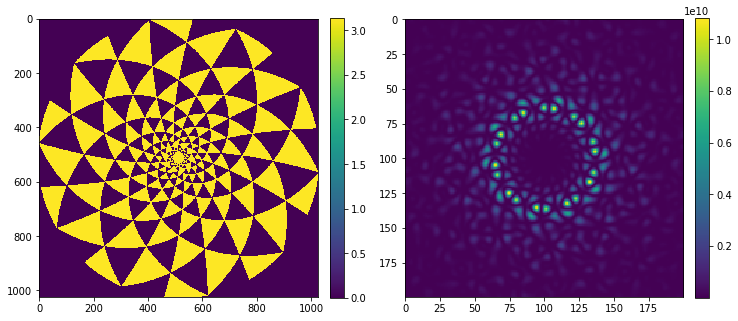

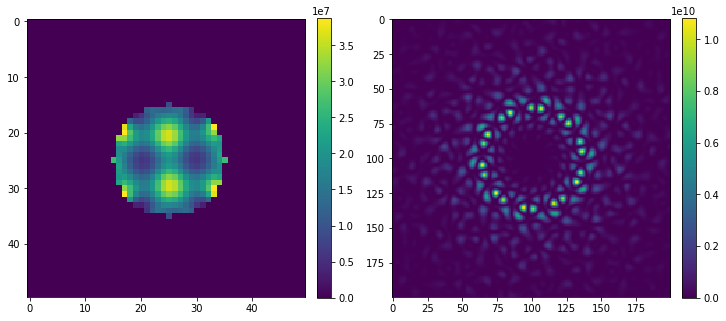

Q: 444.57081
H: 108.47299
Heuristic: 0.36


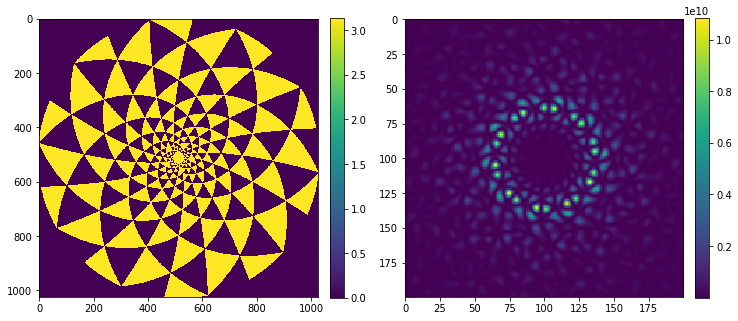

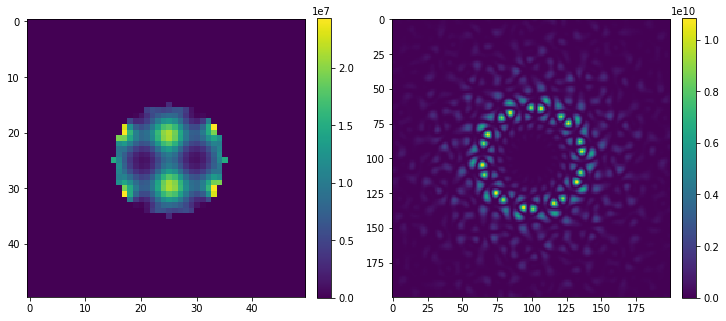

Q: 238.33457
H: 109.22791
Heuristic: 0.15


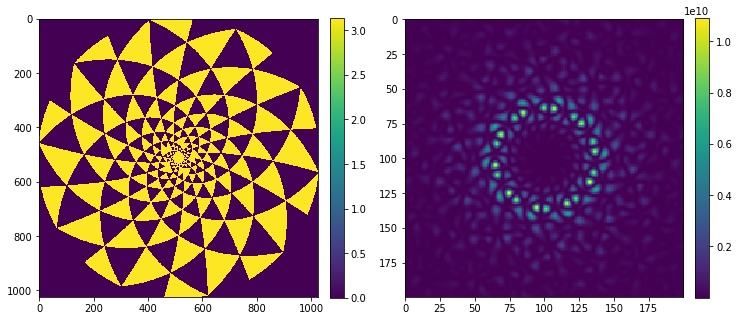

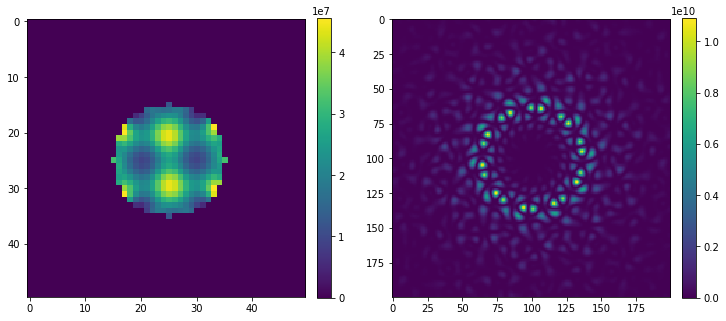

In [512]:

for person in population:
#     print(person)
    print("Q: {:.5f}".format(person[1]))
    print("H: {:.5f}".format(person[0]*1e-8))
    print("Heuristic: {:.2f}".format(person[-1]))
    display(person[3], person[4])
    display_split(person[4], radius=10)

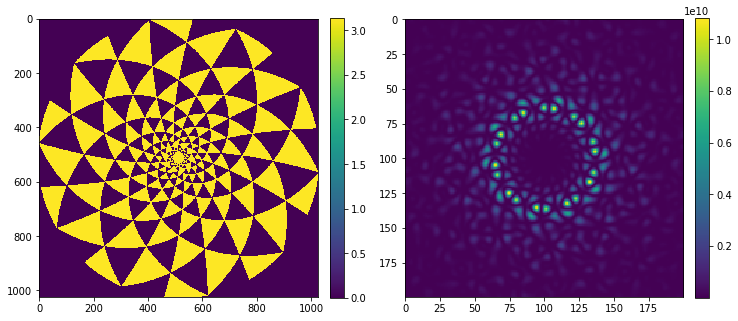

In [523]:
image = population[0][4]
wf = population [0][3]
display(wf,image)

In [521]:
std = np.std(image)

In [522]:
print(std)

174944641.97270674


---

### Sample pupils 

In [14]:
aperture = 0.015                 # Aperture (m)
gridsize = 2048
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]
r_max = split_values[0]
r_min = split_values[-1]

split_even =[15.5, 10.17, 6.83, 4.575, 3.05, 2.07, 1.4, 0.925, 0.62] 
second = [0,0,0,0,0,0,0,0]
fourth = [0,0,0,0,0,0,0,0]

split_odd = [15.5, 12.4, 8.33, 5.6, 3.75, 2.5, 1.7, 1.14, 0.76, 0.62]
first = [0,0,0,0,0,0,0,0,0]
third = [0,0,0,0,0,0,0,0,0]

splits = (split_odd, split_even)
settings = (first, second, third, fourth)

In [38]:
# %%time

# first = [0,0,0,0,0,0,0,0,0]
# third = [0,0,0,0,0,0,0,0,0]

# second = [0,0,0,0,0,0,0,0]
# fourth = [0,0,0,0,0,0,0,0]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [39]:
# %%time

# first = [1,0,0,0,0,0,0,0,0]
# third = [0,0,0,0,0,0,0,0,0]

# second = [0,0,0,0,0,0,0,0]
# fourth = [0,0,0,0,0,0,0,0]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [40]:
# %%time

# first = [0,0,0,1,0,0,0,0,0]
# third = [0,0,0,0,0,0,0,0,0]

# second = [0,0,0,0,0,0,0,0]
# fourth = [0,0,0,0,0,0,0,0]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [41]:
# %%time

# first = [0,0,0,0,0,0,0,0,0]
# third = [0,0,0,0,0,0,0,0,0]

# second = [0,0,0,1,0,0,0,0]
# fourth = [0,0,0,0,0,0,0,0]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [42]:
# %%time

# first = [0,0,0,1,0,0,1,1,1]
# third = [0,0,0,0,0,0,0,0,1]

# second = [0,0,0,0,0,0,1,1]
# fourth = [0,0,0,0,0,0,0,1]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [43]:
# %%time

# first = [1,0,0,0,0,0,0,0,0]
# third = [0,0,0,0,0,0,0,0,0]

# second = [0,0,0,1,0,0,0,0]
# fourth = [0,0,0,0,0,0,0,0]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [44]:
# %%time

# first = [1,0,0,0,0,0,0,0,0]
# third = [0,0,0,0,0,1,0,0,0]

# second = [0,0,0,0,0,0,0,0]
# fourth = [0,0,0,0,0,0,0,0]

# settings = (first, second, third, fourth)

# S0 = generate_individual(settings, gridsize=2048)
# S0 = get_heuristics([S0])[0]

# print("Q: {:.5f}".format(S0[1]))
# print("H: {:.5f}".format(S0[0]*1e-8))
# display(S0[3], S0[4], sizes=(18,18))

In [4]:
%%time

first = [1,0,0,0,0,0,0,1,0]
third = [0,0,0,0,0,0,0,0,1]

second = [0,0,0,0,0,0,0,0]
fourth = [0,0,0,1,0,0,0,0]

settings = (first, second, third, fourth)

S0 = generate_individual(settings, gridsize=2048)
S0 = get_heuristics([S0])[0]

print("Q: {:.5f}".format(S0[1]))
print("H: {:.5f}".format(S0[0]*1e-8))
display(S0[3], S0[4], sizes=(18,18))

NameError: name 'generate_individual' is not defined

---

## Further considerations in pupil design:

The current framework in which to test the pupil is flawed, as we can only fill regions on the base pupil design, meaning we can only further unabalance the pupil, and not explore more novel fillings of the space. Furthermore half filling the trianges is not able to done (greatly increases the search space. 

Ultimately a generalisation to the point of being able to explore changing the actual spiral paramteres would mean that we could begin searching for a truly ideal spiral base upon which to build further. This is feasible as long as we have an accurate way to defining what constitues a 'better' pupil.

Revamping the current method of spiral deisgn to allowing the changing of both the 'black' and the 'white' regions alows for the exploration of more novel pupil designs while still ultimtely maintaining an overall balanced pupil design.

---
### Adding further control over spiral generation

Rather than just being able to turn sections 'on' allow for full control of sprial (on AND off)

Spiral parameters should look more like [1,0,1,0,1,0,1,0] 

In [22]:
def generate_spiral3(gridsize, aperture, r_max, r_min, splits, settings):
    split_odd = splits[0]
    split_even = splits[1]
    first = settings[0]
    second = settings[1]
    third = settings[2]
    fourth = settings[3]
    
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = math.atan2(y, x)
            r = sampling*math.hypot(x,y)
            wfarr[i][j] = spiral3(r, phi, aperture, r_max, r_min, split_odd, split_even, first, second, third, fourth)
    return wfarr

def spiral3(r, phi, aperture, r_max, r_min, split_odd, split_even, first, second, third, fourth):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        
        v = black if (c1*c2*c3>0) else white
        
        if c3 >= 0:
            if sin(chi3/2.) > 0:                  # First  quadrant
                for i in range(len(first)):
                    if (r <= split_odd[i] and r > split_odd[i+1]):
                        if (c1*c2*c3>0):
                            v = black if first[i] == True else white
                        else:
                            v = white if first[i] == True else black
                        return v

            else:                                 # Third quadrant
                for i in range(len(third)):
                    if (r <= split_odd[i] and r > split_odd[i+1]):
                        if (c1*c2*c3>0):
                            v = black if first[i] == True else white
                        else:
                            v = white if first[i] == True else black
                        return v

        else: # In the even regime
            if sin(chi3/2.) <= 0:                 # Second  quadrant
                for i in range(len(second)):
                    if (r <= split_even[i] and r > split_even[i+1]):
                        if (c1*c2*c3>0):
                            v = black if first[i] == True else white
                        else:
                            v = white if first[i] == True else black
                        return v
                    
            else:                                 # Fourth quadrant
                for i in range(len(fourth)):
                    if (r <= split_even[i] and r > split_even[i+1]):
                        if (c1*c2*c3>0):
                            v = black if first[i] == True else white
                        else:
                            v = white if first[i] == True else black
                        return v

    elif r < r_min:
        v = black
    return v

In [47]:
def generate_individual3(settings, prob=0.9, gridsize=1024):
    """
    Individuals are skewed towards to having more empty spaces than filled ones
    If the generated individual has a Q < 1, it is disregarded and a new one is made #CHANGED#
    """
    if settings is None:
        first = np.random.choice(a=[0, 1], size=(1, 8), p=[prob, 1-prob])[0]
        third = np.random.choice(a=[0, 1], size=(1, 8), p=[prob, 1-prob])[0]
        second = np.random.choice(a=[0, 1], size=(1, 9), p=[prob, 1-prob])[0]
        fourth = np.random.choice(a=[0, 1], size=(1, 9), p=[prob, 1-prob])[0]
        settings = [first, second, third, fourth]
        
    wf = generate_spiral3(gridsize, aperture*1e3, r_max, r_min, splits, settings)
    H, Q, FT = test_quality(wf)

    return [H, Q, settings, wf, FT]

def get_heuristics(population, ratio=0.05):
    pop = copy.deepcopy(population)
    
    Qs = []
    Hs = []
    for i  in range(len(pop)):
        Qs.append(pop[i][1])
        Hs.append([pop[i][0],i])
        
    Qnorm = Qs/np.sum(Qs)
    
    # Hs[H, orig_index, ranked_index]
    
    Hs = sorted(Hs, key=itemgetter(0))
    for i in range(len(Hs)):
        Hs[i].append(i)
    Hs = sorted(Hs, key=itemgetter(1))
        
    vals = []
    for Q,H in zip(Qs, Hs):
        val = (np.log(Q)**0.5)*(len(Hs)-H[2])
        vals.append(val)
        
    valnorm = vals/np.sum(vals)
    
    for individual, val in zip(population,valnorm):
        individual.append(val)
    
    return population
        
    # The vals array now contains the new normalised heuristic evalution that takes into account both Q and H


In [53]:
aperture = 0.015                 # Aperture (m)
gridsize = 2048
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]
r_max = split_values[0]
r_min = split_values[-1]

split_even =[15.5, 10.17, 6.83, 4.575, 3.05, 2.07, 1.4, 0.925, 0.62] 
second = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
fourth = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]

split_odd = [15.5, 12.4, 8.33, 5.6, 3.75, 2.5, 1.7, 1.14, 0.76, 0.62]
first = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
third = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]

splits = (split_odd, split_even)
settings = (first, second, third, fourth)

Q: 61.27862
H: 1313.10649


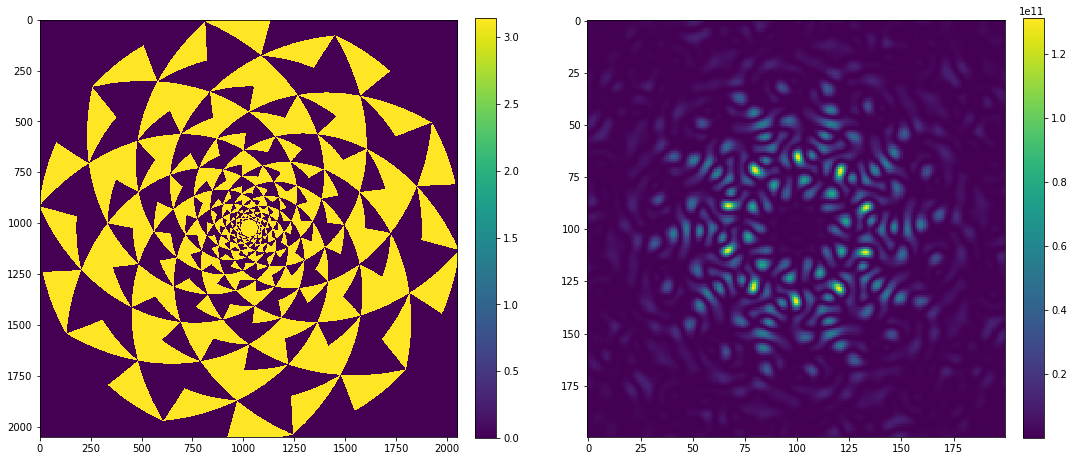

In [54]:
S0 = generate_individual3(settings, gridsize=2048)
S0 = get_heuristics([S0])[0]

print("Q: {:.5f}".format(S0[1]))
print("H: {:.5f}".format(S0[0]*1e-8))
display(S0[3], S0[4], sizes=(18,18))